In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [ ]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import random
import importlib
from pathlib import Path
import re
import matplotlib.image as mpimg

from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Sequential, Conv2d, BatchNorm2d
from torch.nn import SiLU as ReLU
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
from torchvision.transforms import Compose, ToTensor, RandomAffine, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter, Resize
import torch

from dataset import *
from utils import *
from ResNet18_blocks import *
from ResNet50_blocks import *
from training_functions import *

seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

volume_dir = "/mnt/home/u0053/disk/gaia_dataset/CompCars/"

# Neural Network and Deep Learning Project

*Alberto Salvador, Volpi Gaia*



## 1. Dataset

We begin by preprocessing the dataset: we create two csv file containing the **make_id**, **model_id**, **viewpoint** and **image_path** from the *train.txt* and *text_txt* files given by the authors. We then split the dataset in a training, validation and test sets with the *split_val_test* function, specifying which viewpoint an label we're interested in. 

In [4]:
VIEWPOINT = None # can either be None or an integer corresponding to the viewpoint (1,2,3,4,5)
LABEL_TYPE = 'model_id' # 'model_id' or 'make_id'

In [5]:
label_to_index = indexing_labels(volume_dir+"data/train_test_split/classification/train.txt")
print("Nr of models in the train dataset: ", len(label_to_index))

Nr of models in the train dataset:  431


In [6]:
transforms_train = Compose([
    Resize((224, 224)), 
    ToTensor(), #this converts numpy or Pil image to torch tensor and normalizes it in 0, 1
    RandomAffine((0.05, 0.05)),
    RandomHorizontalFlip(),
    RandomVerticalFlip()
])

transforms = Compose([
    Resize((224, 224)),
    ToTensor()
])

In [9]:
# upload the dataset
train, test, val = split_val_test(volume_dir, viewpoint=VIEWPOINT, label_type=LABEL_TYPE)

In [10]:
make_dataset = dataset_factory(
    volume_dir, 
    label_to_index, 
    transforms_train, 
    transforms,
    paths = {
        'train': train[3].tolist(), 
        'test': test[3].tolist(), 
        'valid': val[3].tolist()
    }, 
    labels = {
        "train": (train[1] if LABEL_TYPE == 'model_id' else train[0]).tolist(),
        "test": (test[1] if LABEL_TYPE == 'model_id' else test[0]).tolist(),
        "valid": (val[1] if LABEL_TYPE == 'model_id' else val[0]).tolist()
    }
) # serve per creare la factory che genera i dataset

train_dataset, test_dataset, valid_dataset =  make_dataset()

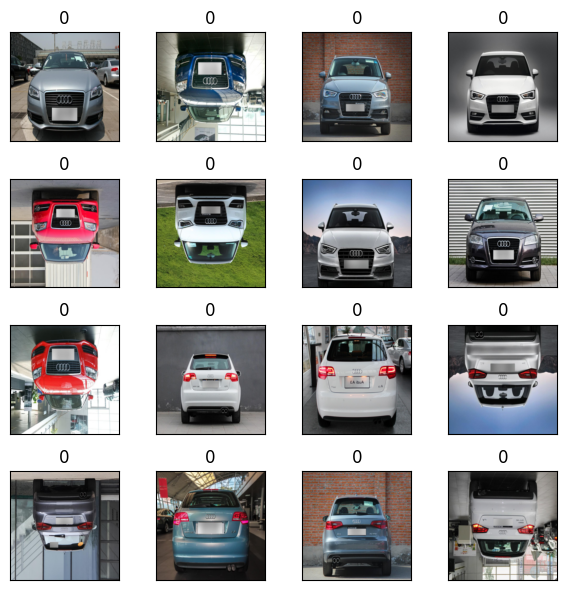

In [11]:
fig, axs = plt.subplots(4, 4, figsize=(6,6))
for i in range(16):
    axs[i//4][i%4].imshow(train_dataset[i][0].permute(1, 2, 0).numpy())
    axs[i//4][i%4].set_xticks([])
    axs[i//4][i%4].set_yticks([])
    axs[i//4][i%4].set_title(f"{train_dataset[i][1]}")
plt.tight_layout()

In [12]:
print(f'train dataset: {len(train_dataset)} \ntest dataset: {len(test_dataset)} \nvalid dataset: {len(valid_dataset)}')

train dataset: 16016 
test dataset: 7469 
valid dataset: 7470


In [13]:
# Here we use the Dataloader function from pytorch to opportunely split the dataset in batches and shuffling data
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())
valid_dataloader = DataLoader(valid_dataset, os.cpu_count()*2, shuffle=False, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_dataset, os.cpu_count()*2, shuffle=False, num_workers=os.cpu_count())

## 2. Model Classification

We will test the performance of two 'different' models on the classification task. 

### 2.1 ResNet18 by scratch

First we start from the ResNet18 architecture implemented by scratch. We use Cross Entropy loss and Adam optimizer, fixing the learning rate to 3e-4 and performing a gridsearch over the weight decay parameter. The results for the training and validation loss are reported below.

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
loss = FocalLoss
epochs = 150

In [ ]:
weight_decays = [1e-5, 1e-4, 5e-4]

for wd in weight_decays:
    model = ResNet18()
    opt = Adam(params=model.parameters(), lr=3e-4, weight_decay=wd)

    print(f"Training with weight decay: {wd}")
    
    train_loss_log, val_loss_log, _ = network_training(
        train_dataloader=train_dataloader, 
        valid_dataloader=valid_dataloader,
        load_checkpoint=load_checkpoint(
            load=False, 
            model=model,
            opt=opt, 
            device=device, 
            volume_dir=volume_dir
        ),
        loss_fn=fix_losses(calcul_class_weights(train_dataloader), loss, device),
        device=device,
        epochs=epochs,
        save_checkpoint=lambda model, opt: save_checkpoint(model, opt, VIEWPOINT or "0", volume_dir),
        save_metric=lambda metric, values: store_metric(volume_dir)(metric, values, VIEWPOINT),
        patience=10,  # patience for early stopping
        skip_first=30
    )

    fig, ax = plot_losses(train_loss_log, val_loss_log, save=True)
    ax.set_title(f"weight_decay={wd}")
    plt.savefig(volume_dir + "gridsearch/"+f"losses_wd{wd}.png")
    plt.show()

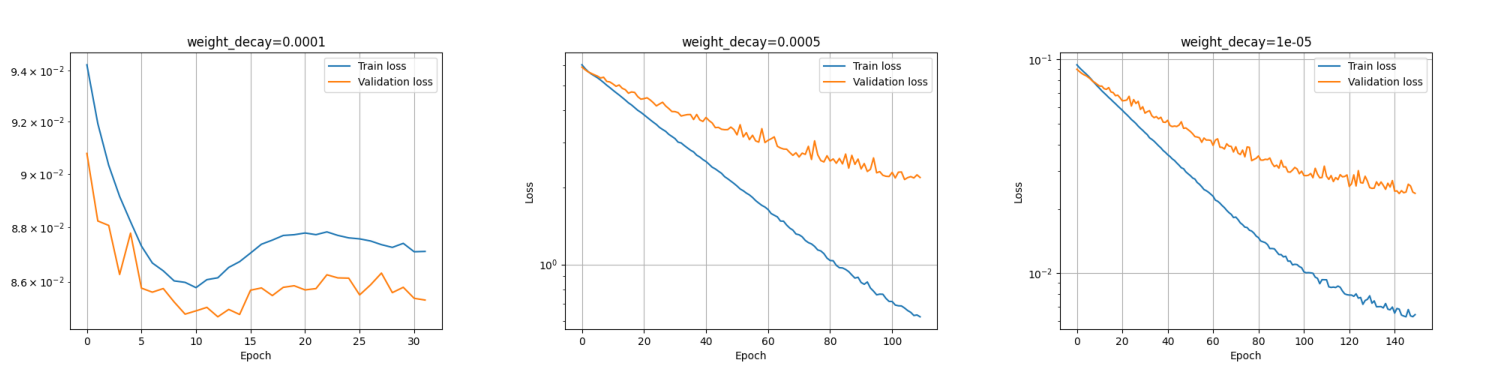

In [19]:
img1 = mpimg.imread(os.path.join(volume_dir, 'gridsearch/losses_wd0.0001.png'))
img2 = mpimg.imread(os.path.join(volume_dir, 'gridsearch/losses_wd0.0005.png'))
img3 = mpimg.imread(os.path.join(volume_dir, 'gridsearch/losses_wd1e-05.png'))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
axes[2].imshow(img3)
axes[2].axis('off')

plt.tight_layout()
plt.show()

By comparing the performances we select *weight_decay*=0.00001. We proceed with the **training on different viewpoints**, using the focal loss, and obtain the top-1 and top-5 error on the task:

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
loss = FocalLoss
epochs = 150
batch_size = 64

In [ ]:
viewpoints=[None,1,2,3,4,5]

for vp in viewpoints:

    model = ResNet18()
    optimizer = Adam(params=model.parameters(), lr=3e-4, weight_decay=1e-5)
    print(f"Training for viewpoint {vp}")

    #splitting the dataset for the current viewpoint
    train, test, val = split_val_test(volume_dir, viewpoint=vp, label_type=LABEL_TYPE)

    # creating the dataset for the current viewpoint
    make_dataset = dataset_factory(
        volume_dir, 
        label_to_index, 
        transforms_train, 
        transforms,
        paths = {
            'train': train[3].tolist(), 
            'test': test[3].tolist(), 
            'valid': val[3].tolist()
        }, 
        labels = {
            "train": (train[1] if LABEL_TYPE == 'model_id' else train[0]).tolist(),
            "test": (test[1] if LABEL_TYPE == 'model_id' else test[0]).tolist(),
            "valid": (val[1] if LABEL_TYPE == 'model_id' else val[0]).tolist()
        }
    ) 
    train_dataset, test_dataset, valid_dataset =  make_dataset()

    # creating the datasetdataloaders for the current viewpoint
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())
    valid_dataloader = DataLoader(valid_dataset, os.cpu_count()*2, shuffle=False, num_workers=os.cpu_count())
    test_dataloader = DataLoader(test_dataset, os.cpu_count()*2, shuffle=False, num_workers=os.cpu_count())

    # training the model for the current viewpoint
    train_loss_log, val_loss_log, best_model = network_training(
        train_dataloader=train_dataloader, 
        valid_dataloader=valid_dataloader,
        load_checkpoint=load_checkpoint(
            load=False, 
            model=model,
            opt=optimizer, 
            device=device, 
            volume_dir=volume_dir
        ),
        loss_fn=fix_losses(calcul_class_weights(train_dataloader), loss, device),
        device=device,
        epochs=epochs,
        save_checkpoint=lambda model, opt: save_checkpoint(model, opt, vp or "0", volume_dir),
        save_metric=lambda metric, values: store_metric(volume_dir)(metric, values, vp),
        patience=10,  # patience for early stopping
        skip_first=20  # skip the first 20 epochs for early stopping
    )

    # evaluate the model on the test set
    topk_score = evaluate_network(test_dataloader, best_model, [1,5], device)

    with open(volume_dir + f'table_3/{LABEL_TYPE}/score_vp{vp or 0}.txt', "w") as f:
        f.write(str(topk_score))

In [12]:
viewpoints=[0,1,2,3,4,5]

for vp in viewpoints:
    with open(volume_dir + f'table_3/{LABEL_TYPE}/score_vp{vp}.txt', "r") as f:
            for line in f:
                  print(f'{vp} - {line}')

0 - {1: 0.4485205411911011, 5: 0.6939349174499512}
1 - {1: 0.03979678079485893, 5: 0.10584250092506409}
2 - {1: 0.012687427923083305, 5: 0.04728950187563896}
3 - {1: 0.03291879966855049, 5: 0.09363570064306259}
4 - {1: 0.31784626841545105, 5: 0.5201910138130188}
5 - {1: 0.039906103163957596, 5: 0.11267605423927307}


### 2.2 ResNet18 **pretrained** on ImageNet

We start again by performing a gridsearch over the best *weight_decay* parameter.

In [12]:
from torchvision.models import resnet18, ResNet18_Weights

device = "cuda" if torch.cuda.is_available() else "cpu"
loss = FocalLoss
epochs = 150

In [ ]:
weight_decays = [1e-5, 1e-4, 5e-4]

for wd in weight_decays:

    #pretrained model from torch
    weights = ResNet18_Weights.DEFAULT
    model_fn = lambda: resnet18(weights)
    model = model_fn()
    # Replace final fully connected layer to match your 431 classes
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(num_ftrs, 431)

    opt = Adam(params=model.parameters(), lr=3e-4, weight_decay=wd)

    print(f"Training with weight decay: {wd}")

    train_loss_log, val_loss_log, best_model = network_training(
        train_dataloader=train_dataloader, 
        valid_dataloader=valid_dataloader,
        load_checkpoint=load_checkpoint(
            load=False, 
            model=model,
            opt=opt, 
            device=device, 
            volume_dir=volume_dir
        ),
        loss_fn=fix_losses(calcul_class_weights(train_dataloader), loss, device),
        device=device,
        epochs=epochs,
        save_checkpoint=lambda model, opt: save_checkpoint(model, opt, VIEWPOINT or "0", volume_dir),
        save_metric=lambda metric, values: store_metric(volume_dir)(metric, values, VIEWPOINT)
    )

    fig, ax = plot_losses(train_loss_log, val_loss_log, save=True)
    ax.set_title(f"weight_decay={wd}")
    plt.savefig(volume_dir + "gridsearch/"+f"losses_pretrained_wd{wd}.png")

    topk_score = evaluate_network(test_dataloader, best_model, [1,5], device)
    print(f'wd:{wd}, {topk_score}')

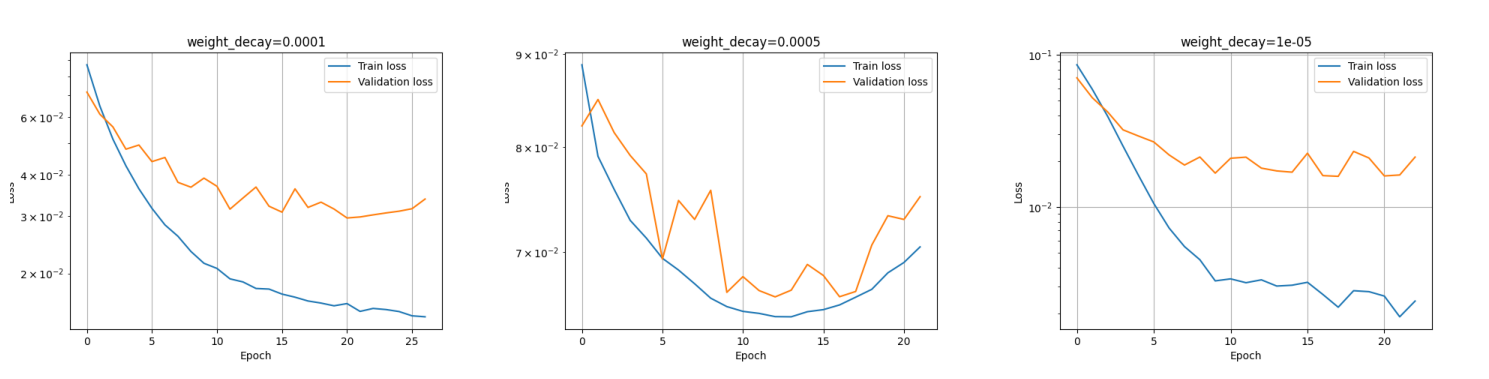

In [21]:
img1 = mpimg.imread(os.path.join(volume_dir, 'gridsearch/losses_pretrained_wd0.0001.png'))
img2 = mpimg.imread(os.path.join(volume_dir, 'gridsearch/losses_pretrained_wd0.0005.png'))
img3 = mpimg.imread(os.path.join(volume_dir, 'gridsearch/losses_pretrained_wd1e-05.png'))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
axes[2].imshow(img3)
axes[2].axis('off')

plt.tight_layout()
plt.show()

By compating the performances, we choose *weight_decay* = 1e-5.

In [ ]:
viewpoints=[1,2,3,4,5]

for vp in viewpoints:

    print(f"Training for viewpoint {vp}")
    
    train, test, val = split_val_test(volume_dir, viewpoint=vp, label_type=LABEL_TYPE)
    make_dataset = dataset_factory(
        volume_dir, 
        label_to_index, 
        transforms_train, 
        transforms,
        paths ={
            'train': train[3].tolist(), 
            'test': test[3].tolist(), 
            'valid': val[3].tolist()
        }, 
        labels = {
            "train": (train[1] if LABEL_TYPE == 'model_id' else train[0]).tolist(),
            "test": (test[1] if LABEL_TYPE == 'model_id' else test[0]).tolist(),
            "valid": (val[1] if LABEL_TYPE == 'model_id' else val[0]).tolist()
        }
    ) 
    train_dataset, test_dataset, valid_dataset =  make_dataset()
    
    batch_size = 64
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())
    valid_dataloader = DataLoader(valid_dataset, os.cpu_count()*2, shuffle=False, num_workers=os.cpu_count())
    test_dataloader = DataLoader(test_dataset, os.cpu_count()*2, shuffle=False, num_workers=os.cpu_count())

    
    train_loss_log, val_loss_log, topk_score = pretrained_training(
        train_dataloader=train_dataloader, 
        valid_dataloader=valid_dataloader,
        test_dataloader=test_dataloader, 
        volume_dir=volume_dir, 
        VIEWPOINT=VIEWPOINT, 
        epochs_fc_train=10, 
        epochs_finetune=100, 
        loss=FocalLoss
    )

    with open(volume_dir + f'table_3/{LABEL_TYPE}/score_pretrained_vp{vp}.txt', "w") as f:
        f.write(str(topk_score))

    plot_losses(train_loss_log, val_loss_log, save=False)

    print("\n\n\n\n\n\n\n\n\n\n")

In [14]:
viewpoints=[0,1,2,3,4,5]

for vp in viewpoints:
    with open(volume_dir + f'table_3/{LABEL_TYPE}/score_pretrained_vp{vp}.txt', "r") as f:
            for line in f:
                  print(f'{vp} - {line}')

0 - {1: 0.735, 5: 0.906}
1 - {1: 0.557, 5: 0.803}
2 - {1: 0.514, 5: 0.728}
3 - {1: 0.518, 5: 0.699}
4 - {1: 0.604, 5: 0.817}
5 - {1: 0.636, 5: 0.810}


## 3. Make Classification

We now switch to make classification, training on different viewpoints with the pretrained model.

In [5]:
VIEWPOINT = None 
LABEL_TYPE = 'make_id' 

label_to_index = indexing_labels(volume_dir+"data/train_test_split/classification/train.txt", label_type=LABEL_TYPE)
print("Nr of models in the train dataset: ", len(label_to_index))

Nr of models in the train dataset:  75


In [ ]:
batch_size = 64
device = "cuda" if torch.cuda.is_available() else "cpu"
loss = FocalLoss

viewpoints=[None,1,2,3,4,5]
for vp in viewpoints:

    print(f"Training for viewpoint {vp}")
    
    train, test, val = split_val_test(volume_dir, viewpoint=vp, label_type=LABEL_TYPE)
    make_dataset = dataset_factory(
        volume_dir, 
        label_to_index, 
        transforms_train, 
        transforms,
        paths ={
            'train': train[3].tolist(), 
            'test': test[3].tolist(), 
            'valid': val[3].tolist()
        }, 
        labels = {
            "train": (train[1] if LABEL_TYPE == 'model_id' else train[0]).tolist(),
            "test": (test[1] if LABEL_TYPE == 'model_id' else test[0]).tolist(),
            "valid": (val[1] if LABEL_TYPE == 'model_id' else val[0]).tolist()
        }
    ) 
    train_dataset, test_dataset, valid_dataset =  make_dataset()
    
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())
    valid_dataloader = DataLoader(valid_dataset, os.cpu_count()*2, shuffle=False, num_workers=os.cpu_count())
    test_dataloader = DataLoader(test_dataset, os.cpu_count()*2, shuffle=False, num_workers=os.cpu_count())
    
    train_loss_log, val_loss_log, best_model = pretrained_training(
        train_dataloader=train_dataloader, 
        valid_dataloader=valid_dataloader,
        loss_fn = loss, 
        device = device,
        volume_dir=volume_dir,
        epochs_fc_train=10, 
        epochs_finetune=100, 
        num_classes=len(label_to_index)

    )

    topk_score = evaluate_network(test_dataloader, best_model, [1,5], device)

    with open(volume_dir + f'table_3/{LABEL_TYPE}/score_pretrained_vp{vp}.txt', "w") as f:
        f.write(str(topk_score))

    plot_losses(train_loss_log, val_loss_log, save=False)
    print("\n\n\n\n\n\n\n\n\n\n")

In [8]:
viewpoints=[None,1,2,3,4,5]
for vp in viewpoints:
    with open(volume_dir + f'table_3/{LABEL_TYPE}/score_pretrained_vp{vp}.txt', "r") as f:
            for line in f:
                  print(f'{vp} - {line}')

None - {1: 0.7947516441345215, 5: 0.9499263167381287}
1 - {1: 0.8058823347091675, 5: 0.9428571462631226}
2 - {1: 0.6319910287857056, 5: 0.854586124420166}
3 - {1: 0.6096140146255493, 5: 0.8368536233901978}
4 - {1: 0.7481545805931091, 5: 0.9227094650268555}
5 - {1: 0.6772300601005554, 5: 0.8949530720710754}
